In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import pyrootutils

base_path = pyrootutils.setup_root(
    search_from=".",
    indicator=[".gitignore"],
    project_root_env_var=True,  # set the PROJECT_ROOT environment variable to root directory
    dotenv=True,  # load environment variables from .env if exists in root directory
    pythonpath=True,  # add root directory to the PYTHONPATH (helps with imports)
    cwd=True,  # change current working directory to the root directory (helps with filepaths)
)
import sys
import pickle
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_geometric as pyg
import pytorch_lightning as pl
from pytorch_lightning.utilities.model_summary import ModelSummary
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (
    RichProgressBar,
    TQDMProgressBar,
    ModelCheckpoint,
)
import wandb
import pandas as pd
from torch_geometric.nn.resolver import (
    activation_resolver,
    normalization_resolver,
)

from src.data.datasets import *
from src.data.datamodules import SpatialDataModule
from src.data.graph_utils import check_radius
from src.data.utils import load_celltypes, load_sample_names
from src.models.modules import DeconvolutionModel, ln_loss, beta_scheduler
from src.models.dissect_spatial import DissectSpatial, DissectHetero, DissectSpatialHybrid
from src.models.dissect import Dissect
from src.utils.utils import seed_everything


from configs.main_config import config


# ignore all warnings
import warnings

warnings.filterwarnings("ignore")

plt.rcParams["figure.dpi"] = 80

# set seeds
seed_everything(seed=42)

## Load data and prepare graph data

In [71]:
data_dir = f"./data"

# experiment_dir = "experiments/experiment_mouse_st"
# sc_data_dir = f"{data_dir}/single-cell"
# sc_file_name = "Allenbrain_forSimulation_uniquect.h5ad"
# st_data_dir = f"{base_path}/data/spatial"
# st_file_name = "V1_Mouse_Brain_Sagittal_Anterior.h5ad"
# radius = 0.02
# st_file_name = "puck_kidney_mus_normal.h5ad"

experiment_dir = "experiments/experiment_kidney_slideSeq_v2_105"
st_data_dir = f"{data_dir}/spatial/simulations_kidney_slideSeq_v2"
st_file_name = "UMOD-KI.KI-4b_resolution105.h5ad"
sc_data_dir = f"{data_dir}/spatial/kidney_slideSeq_v2"
sc_file_name = "UMOD-KI.KI-4b.h5ad"

# slide seq 2
experiment_dir = "experiments/experiment_kidney_slideSeq_v2_UMOD-WT.WT-2a_resolution75"
st_data_dir = f"{data_dir}/spatial/simulations_kidney_slideSeq_v2"
st_file_name = "UMOD-WT.WT-2a_resolution75.h5ad"
sc_data_dir = f"{data_dir}/spatial/kidney_slideSeq_v2"
sc_file_name = "UMOD-WT.WT-2a.h5ad"

# seqfish
# experiment_dir = "experiments/experiment_heart_seqFISH_embryo1_resolution0.11-new"
# # experiment_dir = "experiments/experiment_heart_seqFISH_embryo1_resolution0.11-ica"
# st_data_dir = f"{data_dir}/spatial/simulations_heart_seqFISH"
# st_file_name = "embryo1_resolution0.11.h5ad"
# # st_file_name = "embryo1_resolution0.11_ica.h5ad"
# st_path = f"{st_data_dir}/{st_file_name}"
# sc_data_dir = f"{data_dir}/spatial/heart_seqFISH"
# sc_file_name = "embryo1.h5ad"

In [72]:
st_path = f"{st_data_dir}/{st_file_name}"
seed_everything(seed=42)
radius = 0.05
datamodule = SpatialDataModule(
    st_path=st_path,
    reference_dir=experiment_dir,
    radius=radius,
    p=0.0,
    pin_memory=False,
)
st_data = datamodule.st_data
sc_data = sc.read_h5ad(f"{sc_data_dir}/{sc_file_name}")
# sc.pl.spatial(st_data, color=["endothelial cell"])

Radius: 0.05
Number of nodes: 3244
Number of edges: 52946
Average degree: 32.64241676942047


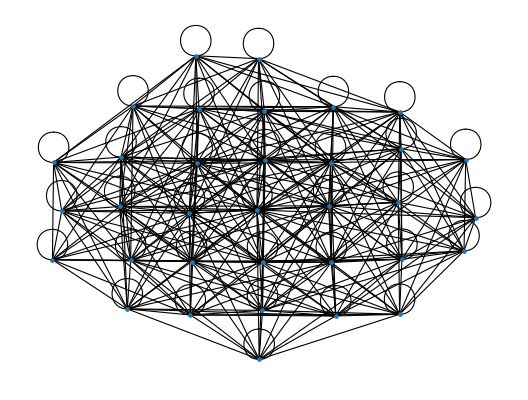

In [73]:
# check graph structure for radius
check_radius(st_data.obsm["spatial"], radius=radius, num_hops=1)

In [74]:
# optional
# train_batch, val_batch = datamodule.check_data()
# from torch_geometric.utils import to_dense_adj, to_dense_batch
# adj = to_dense_adj(train_batch[0].edge_index)
# result = to_dense_batch(train_batch[0].x, train_batch[0].batch)

## Training routine

### Instantiate network

In [75]:
# setup network and model
gnn_encoder_kwargs = {
    "norm": "batch_norm",
    "spatial_channel": True,
    "lin_channel": False,
    "latent_channel": False,
    "fusion": "concat_skip",
    "use_ffn": True,
    "num_layers": 2,
    "num_heads": 1,
}
transformer_kwargs = {
        "norm": "batch_norm",
        "num_heads": 4,
        "use_ffn": True,
        "num_layers": 2,
        "skip_connections": True,
        "ff_hidden_dim": 256,
    }

# encoder_type = "transformer"
encoder_type = "gnn"
net = DissectSpatial(
    num_celltypes=datamodule.num_celltypes,
    latent_dim=128,
    activation="relu6",
    use_pos=True,
    use_id=False,
    encoder_type=encoder_type,
    encoder_kwargs=gnn_encoder_kwargs if encoder_type == "gnn" else transformer_kwargs,
    decoder_kwargs={
        "num_layers": 2,
        "hidden_channels": 64,
    },
)


# hybrid_encoder_kwargs = {
#     "num_gnn_layers": 1,
#     "num_transformer_layers": 1,
#     "dropout": 0.0,
#     "norm": "batch_norm",
#     "num_heads": 4,
#     "spatial_conv_kwargs": {},
#     "ff_hidden_dim": 256,
#     "bias": True,
#     "skip_connections": True,
#     "init_embed_hidden_channels": [512, 256]
# }

# net = DissectSpatialHybrid(
#     num_celltypes=datamodule.num_celltypes,
#     latent_dim=128,
#     activation="relu6",
#     use_pos=True,
#     use_id=False,
#     encoder_kwargs=hybrid_encoder_kwargs,
# )

# net = DissectHetero(
#     num_celltypes=datamodule.num_celltypes,
#     num_genes=datamodule.num_genes,
#     latent_dim=128,
#     activation="relu6",
#     use_pos=False,
#     st_encoder_kwargs=encoder_kwargs,
#     sc_encoder_kwargs=encoder_kwargs,
#     celltype_decoder_kwargs={
#         "num_layers": 2,
#         "hidden_channels": 64,
#     },
#     share_decoder=True,
# )


# net = Dissect(
#     num_genes=datamodule.num_genes,
#     num_celltypes=datamodule.num_celltypes,
#     use_pos=True,
# )

print(net)

DissectSpatial(
  (encoder): MultiChannelGNNEncoder(
    (mlp): MLP(-1, 512, 256, 128)
    (layers): ModuleList(
      (0): MultiChannelGNNBlock(
        (spatial_conv): GATv2Conv(128, 128, heads=1)
        (concat_linear): LazyLinear(in_features=0, out_features=128, bias=True)
        (ffn): FeedForwardBlock(
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (linear2): Linear(in_features=256, out_features=128, bias=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
          (activation): ReLU6()
        )
        (activation): ReLU6()
        (norm1): BatchNorm(128)
        (norm2): BatchNorm(128)
      )
      (1): MultiChannelGNNBlock(
        (spatial_conv): GATv2Conv(128, 128, heads=1)
        (concat_linear): LazyLinear(in_features=0, out_features=128, bias=True)
        (ffn): FeedForwardBlock(
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (linear2)

In [76]:
model = DeconvolutionModel(
    net,
    l1_lambda=0.0,
    l2_lambda=0.0,
    sim_loss_fn="kl_div",
    learning_rate=0.0003256941815506698,
    beta=0.0,
    alpha_max=0.32213534877635946,
    alpha_min=0.023643477904080525,
    move_data_to_device=True,
    weight_decay=0.0000015805827362004355,
    plotting=False,
    save_predictions=False,
)

In [77]:
wandb.finish()
wandb_mode = "online"
# wandb_mode = "disabled"
wandb_logger = WandbLogger(project="dissect-spatial", log_model=True, mode=wandb_mode)

# setup callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="train/total_loss", mode="min", save_last=True, dirpath="checkpoints"
)

# training
trainer = pl.Trainer(
    max_epochs=None,
    max_steps=5000,
    accelerator="gpu",
    limit_train_batches=1,
    log_every_n_steps=1,
    check_val_every_n_epoch=500,
    devices=[7],
    precision=32,
    logger=wandb_logger,
    deterministic="warn",
    enable_checkpointing=True,
    fast_dev_run=True if wandb_mode == "disabled" else False,
    # profiler="simple",
    enable_progress_bar=False,
    callbacks=[checkpoint_callback],
)
trainer.fit(model, datamodule=datamodule)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type           | Params
----------------------------------------
0 | net  | DissectSpatial | 373 K 
----------------------------------------
373 K     Trainable params
0         Non-trainable params
373 K     Total params
1.494     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_steps=5000` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/l1_loss,▄▆▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▄▅▅▆▆▇█
train/l2_loss,▇▅▂▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
train/mix_loss,▁▃▆▇▇▇████▇████████████▇▇█▇█▇▇▆▇█▆█▇▆██▇
train/sim_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation/mean_ccc,▁▅▄▅▅▆▇█▇█
validation/mean_ccc_,▁▅▄▅▅▆▇█▇█
validation/mean_corr,▁▄▄▅▅▆▆▇▇█


In [13]:
# random torch tensor
x = torch.rand(1, 2, 3)
y = torch.rand(2, 3)
print(x.shape, y.shape)
print((x + y).shape)

torch.Size([1, 2, 3]) torch.Size([2, 3])
torch.Size([1, 2, 3])


In [171]:
list(net.encoder_real.parameters())[0]

Parameter containing:
tensor([[ 0.0121, -0.0523, -0.0108,  ...,  0.0433,  0.0356,  0.0270],
        [-0.0268, -0.0068, -0.0096,  ...,  0.0324, -0.0315, -0.0315],
        [-0.0129, -0.0412,  0.0223,  ...,  0.0082,  0.0299,  0.0263],
        ...,
        [-0.0122,  0.0420,  0.0386,  ...,  0.0002, -0.0525, -0.0508],
        [-0.0026, -0.0359,  0.0492,  ...,  0.0047,  0.0051, -0.0051],
        [-0.0377, -0.0100, -0.0056,  ...,  0.0073,  0.0465, -0.0047]],
       requires_grad=True)

In [172]:
list(net.encoder_sim.parameters())[0]

Parameter containing:
tensor([[ 0.0120, -0.0523, -0.0109,  ...,  0.0433,  0.0356,  0.0270],
        [-0.0268, -0.0068, -0.0096,  ...,  0.0324, -0.0315, -0.0315],
        [-0.0130, -0.0412,  0.0223,  ...,  0.0082,  0.0299,  0.0263],
        ...,
        [-0.0122,  0.0420,  0.0386,  ...,  0.0002, -0.0525, -0.0508],
        [-0.0026, -0.0360,  0.0492,  ...,  0.0046,  0.0051, -0.0051],
        [-0.0377, -0.0100, -0.0056,  ...,  0.0073,  0.0465, -0.0047]],
       requires_grad=True)

In [ ]:
summary = ModelSummary(model, max_depth=-1)
print(summary)

## Load trained model

In [ ]:
# TODO

In [ ]:
l1_loss = ln_loss(net, n=1, ln_lambda=1e-5, only_matrices=True)
l2_loss = ln_loss(net, n=2, ln_lambda=1e-5, only_matrices=True)
total_loss = l1_loss + l2_loss
# print losses
print("l1_loss: ", l1_loss)
print("l2_loss: ", l2_loss)
print("total_loss: ", total_loss)

### Init model with tensorflow weights

In [ ]:
# load weight matrices and overwrite model weights with them
# load with pickle
with open("experiment/model_0/trained_weights.pkl", "rb") as f:
    trained_weights = pickle.load(f)
weight_names = list(trained_weights.keys())
for k, weight in enumerate(net.parameters()):
    trained_weight = trained_weights[weight_names[k]].transpose()
    print(weight.shape, trained_weight.shape)
    assert weight.shape[0] == trained_weight.shape[0]
    if len(weight.shape) == 2:
        assert weight.shape[1] == trained_weight.shape[1]
    weight.data = torch.from_numpy(trained_weight).float()

In [ ]:
l1_loss = ln_loss(net, n=1, alpha=1e-5, only_matrices=True)
l2_loss = ln_loss(net, n=2, alpha=1e-5, only_matrices=True)
total_loss = l1_loss + l2_loss
# print losses
print("l1_loss: ", l1_loss)
print("l2_loss: ", l2_loss)
print("total_loss: ", total_loss)

## Perform actual deconvolution

In [ ]:
result = trainer.predict(model, test_loader)

## Save results

In [ ]:
# save results to csv
result_df = pd.DataFrame(result[0])
result_df.columns = celltype_names
result_df.index = sample_names
result_df.to_csv(f"{experiment_dir}/gnn_predictions.csv")

## Evaluate result

### On Bulk data

In [ ]:
y_real_hat = result[0].numpy()
rmse, mean_corr = compare_with_gt(y_real_hat, y_real)
print("RMSE: ", rmse)
print("Mean Corr: ", mean_corr)

### On spatial data

In [ ]:
# extract max cell type per node
cell_type_indices = np.array(np.argmax(result[0], axis=1))
# map celltypes onto cdelltype list
cell_types = [celltype_names[i] for i in cell_type_indices]
# add new column to adata
st_data.obs["celltype"] = cell_types

sq.pl.spatial_scatter(st_data, color=["celltype"])
del st_data.uns["celltype_colors"]

In [ ]:
predictions = pd.DataFrame(result[0], columns=celltype_names, index=st_data.obs.index)
for col in predictions.columns:
    st_data.obs[col] = predictions[col]
sq.pl.spatial_scatter(st_data, color=celltype_names)